# Intro to Reinforcement Learning


[Need to update this picture]

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/prac_intro_to_rl/intro_to_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:**
Claude Formanek

**Introduction:** 

Reinforcement Learning

**Topics:** 

Content: Reinforcement Learning

Level: Beginner

**Aims/Learning Objectives:**

[Points on the exact learning outcomes from the prac. This should probably be <=5 things.]

**Prerequisites:**

[Knowledge required for this prac. You can link a relevant parallel track session, blogs, papers, courses, topics etc.]

**Outline:** 

[Points that link to each section.]

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.


## Setup

For this practical, it will help to use a GPU runtime to speed up training. To do this, go to the `Runtime` menu in Colab, select `Change runtime type` and then in the popup menu, choose `GPU` in the `Hardware accelerator` box.

In [7]:
# @title Install required packages (Run Cell)
# %%capture
!pip install jaxlib
!pip install jax
!pip install git+https://github.com/deepmind/dm-haiku
!pip install gym
!pip install gym[box2d]
!pip install rlax
!pip install optax
!pip install matplotlib

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-54x2wm0l
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-54x2wm0l
  Resolved https://github.com/deepmind/dm-haiku to commit d6e3c2085253735c3179018be495ebabf1e6b17c
  Using cached matplotlib-3.5.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
     |████████████████████████████████| 3.2 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 944 kB 8.2 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [8]:
# @title Import required packages (Run Cell)
# %%capture
import random
import collections # useful data structures
import numpy as np
import gym # reinforcement learning environments
import jax
import jax.numpy as jnp # jax numpy
import haiku as hk # jax neural network library
import optax # jax optimizer library
import rlax # jax reinforcement learning library
import matplotlib.pyplot as plt # graph plotting library



## Section 1: Key Concepts in Reinforcement Learning

Reinforcement Learning (RL) is a subfield of Machine Learning (ML). RL algorithms try to learn the optimal actions to take in an environment in order to maximise some reward signal. More precicely, in RL we have an **agent** which percieves an observation $o_t$ of the current state $s_t$ of the **environment** and must choose an action $a_t$ to take. The environment then transitions to a new state $s_{t+1}$ in response to the agents action and also gives the the agent a scalar reward $r_t$ to indicate how good or bad the chosen action was given the environment's state. The goal in RL is for the agent to maximise the ammount of reward it receives from the environment over time. The subscipt $t$ is used to indicate the timestep number, i.e., $s_0$ is the state of the environment at the initial timestep and $a_{99}$ is the agent's action at the $99th$ timestep. 

### OpenAI Gym
OpenAI has provided a Python package called Gym that includes implementations of popular environments and a simple interface for an RL agent to interact with. To create a gym environment, all you need to do is pass the name of the environment to the function `gym.make(<environment_name>)`. In this tutorial we will be using a simple environment called CartPole. In **CartPole** the task is for the agent to learn to balance the pole for as long as possible by moving the cart *left* or *right*.

<img src="https://miro.medium.com/max/600/1*v8KcdjfVGf39yvTpXDTCGQ.gif" width="30%" />

In [9]:
# Create the environment
env = gym.make("CartPole-v1")

/home/claude/miniconda3/envs/indaba-prac/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### States and observations
In RL the agent perceives an observation of environments state. In some settings the observation may include all the information underlying the environment's state. Such an envrionment is called **fully observed**. In other settings the the agent may only receive partial information about the environment's state in its observation. Such an environment is called **partially observed**. For the rest of this tutorial we will assume the environment is fully observed and so we will use state $s_t$ and observation $o_t$ interchangeably. In Gym we get the initial observation from the environment by calling the function `env.reset()`: 

In [10]:
# Reset the environment
s_0 = env.reset()
print("Initial State::", s_0)

Initial State:: [-0.03015566 -0.04560914  0.04607056  0.02550874]


In CartPole the state of the environment is represented by four numbers; *angular position of the pole, angular velocity of the pole, position of the cart, velocity of the cart*. 

### Actions
In RL actions are usually either **discrete** or **continuous**. Continous actions are given by a vector of real numbers. Discrete actions are given by an integer value. In environments where we can count out the finite set of actions we usually use discrete actions. In CartPole there are only two actions; *left and right*. As such, the actions can be represented by integers $0$ and $1$. In gym we can easily get the list of possible actions:

In [11]:
# Get action space
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Environment action space: Discrete(2)
Number of actions: 2


### The agent's policy
In RL the agent choses actions based on the observation it receives. We can think of the agent's action selection process as a function that takes an observation as input and returns an action as output. In RL we usually call this function the agent's **policy** and denote it $\pi(s_t)=a_t$. 

In some cases we may want our policy to be stocastic, rather than deterministic. In such cases, actions are actiually randomly sampled from a probability distribution that is conditiond on the observation. We denote stocastic policies $a_t\sim\pi(\cdot\ |\ s_t)$, where the symbol $\cdot$ is simply a shorthand for *all actions* and $~$ means "*sampled from*".

**Exercise 1:** If Bob has a deterministic policy $\pi$ and the first time Bob uses his policy on some observation $o_t$ he choses action $0$. What will Bob's chosen action be if he uses his policy a second time on the exact same observation $o_t$. Chose from the options below and assume there are only two possible actions:
1.   Bob will chose action 0 again.
2.   Bob will chose action 1.
3.   You can't say.

**Exercise 2:**  If Alice has a stocastic policy $\pi$ and the first time Alice uses her policy on some observation $o_t$ she choses action $0$. What will Alice's chosen action be if she uses her policy a second time on the exact same observation $o_t$. Chose from the options below and assume there are only two possible actions:
1.   Alice will chose action 0 again.
2.   Alice will chose action 1.
3.   You can't say.

In [12]:
#@title Exercise 1 & 2 solution
# %%capture

""" 
Exercise 1: Since the policy is deterministic, Bob will always choose the same 
action given the same observation.

Exercise 2: Since the policy is stocastic, the result from Alice's policy will be
random. So you can't say.
"""

" \nExercise 1: Since the policy is deterministic, Bob will always choose the same \naction given the same observation.\n\nExercise 2: Since the policy is stocastic, the result from Alice's policy will be\nrandom. So you can't say.\n"

As an exercise we will implement a stocastic policy as well as a deterministic policy for CartPole. 

**Exercise 3:** Complete the function below which should take an observation `obs` as input, compute the dot product between the `obs` and parameter vector `params=[1,-2,2,-1]` and then return a `0` if the result is less than or equal to zero and a `1` if the result is greater than zero. Is this a deterministic or stocastic policy?

**Usefull methods:** 
*   [Numpy dot product](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)


**Notes:**

*   We already imported `numpy` as `np`.
*   Assume `obs` is also a vector of four numbers like `params`.

In [ ]:
def choose_action(obs):

  # YOUR CODE


  # END YOUR CODE

  return action

In [13]:
#@title Exercise 3 solution

def choose_action(obs):

  weights = np.array([1,-2,2,-1])
  dot_product = np.dot(obs, weights)

  if dot_product >= 0:
    action = 0
  else:
    action = 1

  return action

# TESTS
fixed_obs = [1,1,2,4]
print(f"Fixed observation: {fixed_obs}")
for i in range(10):
  print(f"Result of policy call number {i}: {choose_action(fixed_obs)}")



Fixed observation: [1, 1, 2, 4]
Result of policy call number 0: 1
Result of policy call number 1: 1
Result of policy call number 2: 1
Result of policy call number 3: 1
Result of policy call number 4: 1
Result of policy call number 5: 1
Result of policy call number 6: 1
Result of policy call number 7: 1
Result of policy call number 8: 1
Result of policy call number 9: 1


**Exercise 4:** Complete the function below which should take an observation `obs` as input, compute the dot product between the `obs` and parameter vector `params=[1,-2,2,-1]` and then return a `0` 20% of the time and a `1` 80% of the time if the result is less than or equal to zero. If the result of the dot-product is greater than zero the function should return a `0` 100% of the time. Is this a deterministic or stocastic policy?

**Usefull methods:** 
*   [Numpy random choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

In [14]:
def choose_action(obs):

  weights = np.array([1,-2,2,-1])
  action = None # you will need to overwrite this

  # YOUR CODE


  # END YOUR CODE

  return action

# TESTS
fixed_obs = [1,1,2,4]
print(f"Fixed observation: {fixed_obs}")
for i in range(10):
  print(f"Result of policy call number {i}: {choose_action(fixed_obs)}")

Fixed observation: [1, 1, 2, 4]
Result of policy call number 0: None
Result of policy call number 1: None
Result of policy call number 2: None
Result of policy call number 3: None
Result of policy call number 4: None
Result of policy call number 5: None
Result of policy call number 6: None
Result of policy call number 7: None
Result of policy call number 8: None
Result of policy call number 9: None


In [15]:
#@title Exercise 4 solution

def choose_action(obs):

  weights = np.array([1,-2,2,-1])
  dot_product = np.dot(obs, weights)

  if dot_product <= 0:
    action = np.random.choice([0,1], p=[0.2, 0.8])
  else:
    action = 0

  return action

# TESTS
fixed_obs = [1,1,2,4]
print(f"Fixed observation: {fixed_obs}")
for i in range(10):
  print(f"Result of policy call number {i}: {choose_action(fixed_obs)}")



Fixed observation: [1, 1, 2, 4]
Result of policy call number 0: 0
Result of policy call number 1: 1
Result of policy call number 2: 1
Result of policy call number 3: 1
Result of policy call number 4: 1
Result of policy call number 5: 1
Result of policy call number 6: 1
Result of policy call number 7: 1
Result of policy call number 8: 1
Result of policy call number 9: 1


### The environment transition function
Now that we have a policy we can pass actions from the agent to the environment. The environment will the transition into a new state in response to the agent's action. In RL we model this process by a **state transition function** $P$ which takes the current state $s_t$ and an action $a_t$ as input and returns the next state $s_{t+1}$ as output. Like with policies, the state transiton function can either be deterministic $s_{t+1}=P(s_t, a_t)$ or it can be stocastic $s_{t+1}\sim P(\cdot\ |\ s_t, a_t)$. In gym we can pass actions to the environment by calling the `env.step(<action>)` function. The function will then return four values; the next observation, the reward for the action taken, a boolean flag to indicate if the game is done and finally some extra information.


In [16]:
# Get the initial obs by resetting the env
initial_obs = env.reset()

# Use the policy to chose an action
action = choose_action(initial_obs)

# Step the environment
next_obs, reward, done, info = env.step(action)

print("Observation:", initial_obs)
print("Action:", action)
print("Next observation:", next_obs)
print("Reward:", reward)
print("Game is done:", done)

Observation: [-0.04586864  0.0271866  -0.04945642  0.0103842 ]
Action: 1
Next observation: [-0.04532491  0.22298165 -0.04924874 -0.29748353]
Reward: 1.0
Game is done: False


### Episode return
In RL we usually break the agents interactions with the environment up into **episodes**. The sum of all reward collected during an episode is what we call the episode's **return**. The goal in RL is for the agent to chose actions which maximise the expected future return. In CartPole the agent receives a reward of `1` for every timestep the pole is still upright. If the pole falls over, the game is over and the agent receives a reward of `0`.

### Agent-environment Loop
Now that we know what a policy is and we know how to step the environment, lets close the agent-environment loop.

**Exercise 5:** Write a function which runs one episode of CartPole by sequentially choosing actions and stepping the environment. You should use the stocastic policy we defined earlier to chose actions. The function should keep track of the reward received and output the return at the end of the episode.

In [ ]:
def run_episode(env):
  episode_return = 0

  ## YOUR CODE

  # HINT: reset environment

  # HINT: while loop until episode is done

    # HINT: choose action

    # HINT: step environment
    
    # HINT: add reward to episode_return

  ## END CODE

  return episode_return

In [17]:
#@title Exercise 5 solution

def run_episode(env):
  episode_return = 0
  
  obs = env.reset()
  done = False

  while not done:
    action = choose_action(obs)

    next_obs, reward, done, info = env.step(action)

    episode_return += reward

    # Critical
    obs = next_obs

  return episode_return

# TEST
print("Episode return:", run_episode(env))

Episode return: 9.0


In CartPole, the environment is considered solved when the agent can reliably achieve an episode return of 500. As you can see, our current policy is nowhere near optimal yet. Lets learn a way to find an optimal policy.

One way we can find an optimal policy is by randomly searching for it. Obviously in a complex environment finding an optimal policy by randomly trying differnet strategies could take forever. But CartPole is a sufficiently simple environment that it might just work.

Before we implement random policy search, lets take a look at the following environment loop function that we implemented for you. Its the environmentloop we will be using for the rest of the notebook. We will use a [NamedTuple](https://www.geeksforgeeks.org/namedtuple-in-python/) to bundle `obs`, `action`, `reward`, `next_obs` and the done flag into a **transition** object.

In [18]:
# Named tuple to store transition
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "done"])

# TEST
transition = Transition(
    obs=[1,2,-1,2],
    action=0,
    reward=10,
    next_obs=[1,2,2,1],
    done=True
)

print("Transition obs:", transition.obs)
print("Transition action:", transition.action)
print("Transition reward:", transition.reward)
print("Transition next obs:", transition.next_obs)
print("Transition done:", transition.done)

Transition obs: [1, 2, -1, 2]
Transition action: 0
Transition reward: 10
Transition next obs: [1, 2, 2, 1]
Transition done: True


Below is the environment loop function we have implemented for you. We reccomend reading through it and trying to understand it, but if anything is unclear, don't worry about it. It should all make more sense as we work through this tutorial.

In [138]:
# Environment loop
def run_environment_loop(rng, env, agent_params, agent_select_action_func, 
    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None, 
    agent_memory=None, num_episodes=1000, evaluator_period=100, 
    evaluation_episodes=32, learn_steps_per_episode=1):
    """
    This function runs several episodes in an environment and periodically does 
    some agent learning and evaluation.
    
    Args:
        rng: a random number generator. This is for jax.
        env: a gym environment.
        agent_params: an object to store parameters that the agent uses.
        agent_select_func: a function that does action selection for the agent.
        agent_actor_state (optional): an object that stores the internal state 
            of the agents action selection function.
        agent_learn_func (optional): a function that does some learning for the 
            agent by updating the agent parameters.
        agent_learn_state (optional): an object that stores the internal state 
            of the agent learn function.
        agent_memory (optional): an object for storing an retrieving historical 
            experience.
        num_episodes: how many episodes to run.
        evaluator_period: how often to run evaluation.
        evaluation_episodes: how many evaluation episodes to run.

    Returns:
        episode_returns: list of all the episode returns.
        evaluator_episode_returns: list of all the evaluator episode returns.
    """
    episode_returns = [] # List to store history of episode returns.
    evaluator_episode_returns = [] # List to store history of evaluator returns.
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()
        episode_return = 0
        done = False

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng), 
                                            agent_params, 
                                            agent_actor_state, 
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, done, _ = env.step(int(action))

            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, done)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward

            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng), 
                                                        agent_params, 
                                                        agent_learner_state, 
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = env.reset()
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng), 
                                    agent_params, 
                                    agent_actor_state, 
                                    np.array(obs), 
                                    evaluation=True
                                )

                    obs, reward, done, _ = env.step(int(action))

                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    return episode_returns, evaluator_episode_returns

Before we can test this environment loop function with our policy function we implemented earlier, we will need to modify it so that its interface matches the way our environment loop expects it. The `select_action` function should take a random seed in the first argument position, then parameters, then the actors internal state (more on this later), then the observation and finally a `evaluation` boolean flag that indicates if the function is being called during the evaluation loop or not (more on this later). The function should return the chosen action and the next state of the actor.

In [20]:
def select_action(key, params, actor_state, obs, evaluation=False):
    """
    This function assums params is a vecotor of same size as obs.
    It computes the dot product between params and obs. If the result is
    less than zero it returns actions zero. If the result is greater than
    or equal to zero, it returns action 1.
    """
    dot_product = np.dot(params, obs)
    
    if dot_product >= 0:
      action = 1
    else:
      action = 0

    return action, actor_state

**Exercise 6:** Can you convert this into a function that only uses Jax methods so that we can jit the function?


**Useful functions:** 
*   [Jax dot product](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.dot.html)
*   [Jax select](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.select.html#jax.lax.select)

**Note:**

We already imported `jax.numpy` as `jnp`.



In [ ]:
def select_action(key, params, actor_state, obs, evaluation=False):

  # YOUR CODE

  # END YOUR CODE

  return action, actor_state

# TEST: the result of your function should be action 1 in this test
key = None # not used
actor_state = None # not used
select_action_jit = jax.jit(select_action) # jit the function
params = np.array([1,1,-1,-1], "float32")
obs = np.array([1,1,1,1], "float32")

action, actor_state = select_action_jit(key, params, actor_state, obs)
print("Action:", action)

In [21]:
#@title Exercise 6 solution

def select_action(key, params, actor_state, obs, evaluation=False):
    dot_product = jnp.dot(params, obs)

    action = jax.lax.select(
        dot_product >= 0.0,
        1,
        0,
    )

    return action, actor_state

# TEST: the result of your function should be action 1 in this test
key = None # not used
actor_state = None # not used
select_action_jit = jax.jit(select_action) # jit the function

params = np.array([1,1,-1,-1], "float32")
obs = np.array([1,1,1,1], "float32")

action, actor_state = select_action_jit(key, params, actor_state, obs)
print("Action:", action)

Action: 1


We can now test our `select_action` function in the `run_environment_loop` function.

In [22]:
# Jax random number generator
rng = hk.PRNGSequence(jax.random.PRNGKey(0)) # don't worry about this for now

# Some arbitrary parameters
params = np.array([1,1,-1,-1], "float32")

episode_returns, evaluator_returns = run_environment_loop(
                                        rng, 
                                        env, 
                                        params,
                                        select_action_jit,
                                        num_episodes=1001,
                                      )

print("Average episode returns:", np.mean(episode_returns))

Episode: 0	Episode Return: 8.0	Average Episode Return: 8.0	Evaluator Episode Return: 9.0625
Episode: 100	Episode Return: 8.0	Average Episode Return: 9.25	Evaluator Episode Return: 8.90625
Episode: 200	Episode Return: 9.0	Average Episode Return: 8.85	Evaluator Episode Return: 9.15625
Episode: 300	Episode Return: 8.0	Average Episode Return: 8.95	Evaluator Episode Return: 8.96875
Episode: 400	Episode Return: 10.0	Average Episode Return: 9.15	Evaluator Episode Return: 9.03125
Episode: 500	Episode Return: 9.0	Average Episode Return: 9.1	Evaluator Episode Return: 8.9375
Episode: 600	Episode Return: 8.0	Average Episode Return: 9.0	Evaluator Episode Return: 8.84375
Episode: 700	Episode Return: 9.0	Average Episode Return: 9.05	Evaluator Episode Return: 9.0
Episode: 800	Episode Return: 9.0	Average Episode Return: 9.4	Evaluator Episode Return: 9.15625
Episode: 900	Episode Return: 9.0	Average Episode Return: 9.0	Evaluator Episode Return: 9.0
Episode: 1000	Episode Return: 9.0	Average Episode Return

### Agent memory

In many RL algorithms the agent uses a kind of memory to store some of the experiences it had in the environment. The interface we will use for the agent's memory is very simple. It will have a function `memory.push(<transition>)` that adds some information about the transition to the memory, a function `memory.is_ready()` to check if the memory is ready to do some learning, and fianlly a function `memory.sample()` that returns some information that the agent learn function can use to do learning.

#### Average Episode Return Memory
We have built a simple agent memory module for you below. It stores the `epsisode_returns` of the last 20 episodes. Read through our implementation below and see if you can understand it. The `memory.sample()` method returns the average episode return over the last 20 episodes.

In [23]:
# A NamedTuple to store the average episode return of the last 20 runs
AverageEpisodeReturnMemory = collections.namedtuple(
                                "AverageEpisodeReturnMemory", 
                                ["average_episode_return"]
                            )

class AverageEpisodeReturnBuffer:

    def __init__(self, num_episodes_to_store=20):
        """
        This class implements an agent memory that stores the average episode 
        return over the last 20 episodes.
        """
        self.num_episodes_to_store = num_episodes_to_store
        self.episode_return_buffer = []
        self.current_episode_return = 0

    def push(self, transition):
        self.current_episode_return += transition.reward

        if transition.done: # If the episode is done
            # Add episode return to buffer
            self.episode_return_buffer.append(self.current_episode_return)

            # Reset episode return
            self.current_episode_return = 0


    def is_ready(self):
        return len(self.episode_return_buffer) == self.num_episodes_to_store

    def sample(self):
        average_episode_return = np.mean(self.episode_return_buffer)

        # Clear episode return buffer
        self.episode_return_buffer = []

        return AverageEpisodeReturnMemory(average_episode_return)

## Section 2: Random Policy Search (RPS)
Now we are ready to implement the random policy search algorithm which will randomly try different policies and keep track of the best policy it has found so far. We will say that policy $A$ is better than policy $B$ if the average episode return policy $A$ achieved over the last 20 episodes is greater than that of policy $B$. We will need to modify the way we store the agents parameters so that we always have access to the latest parameters as well as the best parameters.

In [24]:
# Parameter container for random policy search
RandomPolicySearchParams = collections.namedtuple("RandomPolicySearchParams", ["current", "best"])

# TEST: store two different sets of parameters
current_params = np.array([1,1,-1,-1])
best_params = np.array([0,0,0,0])
rps_params = RandomPolicySearchParams(current_params, best_params)

print(f"Best params: {rps_params.best}")
print(f"Current params: {rps_params.current}")

Best params: [0 0 0 0]
Current params: [ 1  1 -1 -1]


### RPS select action function
Now lets once again modify our `select_action` function such that it uses the best parameters when when `evaluation==True` and uses the current parameters when `evaluation==False`.

**Exercise 7:** Implement the `random_policy_search_select_action` function as described above. Make sure you use Jax so that we can jit the function.

In [25]:
def random_policy_search_select_action(
    key, 
    params, 
    actor_state, 
    obs, 
    evaluation=False
):

  # YOUR CODE

  # HINT: best_action = ... (two lines)

  # HINT: current_action = ... (two lines)

  # HINT: action = best_action if evaluation else current action (one line)

  # END YOUR CODE

  return action, actor_state

# TEST:
key = None # not used
actor_state = None # not used
random_policy_search_select_action_jit = jax.jit(
                                            random_policy_search_select_action
                                            ) # jit the function
# Parameters
current_params = np.array([-1,-1,-1,-1])
best_params = np.array([0,0,0,0])
rps_params = RandomPolicySearchParams(current_params, best_params)

# Observation
obs = np.array([1,1,1,1], "float32")

current_action, actor_state = random_policy_search_select_action_jit(
    key, 
    rps_params, 
    actor_state, 
    obs, 
    evaluation=False
)

best_action, actor_state = random_policy_search_select_action_jit(
    key, 
    rps_params, 
    actor_state, 
    obs, 
    evaluation=True
)

print("Current action:", current_action)
print("Best action:", best_action)

Current action: 1
Best action: 1


In [26]:
#@title Exercise 7 solution

def random_policy_search_select_action(
    key, 
    params, 
    actor_state, 
    obs, 
    evaluation=False
):

  # YOUR CODE

  dot_product = jnp.dot(params.best, obs)
  best_action = jax.lax.select(
      dot_product >= 0,
      1,
      0
  )

  dot_product = jnp.dot(params.current, obs)
  current_action = jax.lax.select(
      dot_product >= 0,
      1,
      0
  )

  action = jax.lax.select(
      evaluation,
      best_action,
      current_action
  )

  # END YOUR CODE

  return action, actor_state

# TEST:
key = None # not used
actor_state = None # not used
random_policy_search_select_action_jit = jax.jit(
                                            random_policy_search_select_action
                                            ) # jit the function
# Parameters
current_params = np.array([-1,-1,-1,-1])
best_params = np.array([0,0,0,0])
rps_params = RandomPolicySearchParams(current_params, best_params)

# Observation
obs = np.array([1,1,1,1], "float32")

current_action, actor_state = random_policy_search_select_action_jit(
    key, 
    rps_params, 
    actor_state, 
    obs, 
    evaluation=False
)

best_action, actor_state = random_policy_search_select_action_jit(
    key, 
    rps_params, 
    actor_state, 
    obs, 
    evaluation=True
)

print("Current action:", current_action)
print("Best action:", best_action)


Current action: 0
Best action: 1


### RPS learn function
Now we need to implement a learn function for our random policy search agent. The learn function is quite simple. All we need to do is check if the current weights are better than the best weights. If they are better, then set the current weights to be the new best weights and randomly sample a new set of current weights. Lets assume our learn function receives a memory from the AverageEpisodeReturnMemory we implmented earlier. We can uses this to compare the current weights to the best weights. We will need to keep track of the best average episode return for the learn function. For that we can use the `learn_state` argument.

In [27]:
# A NamedTuple to store the best average episode return so far
LearnerState = collections.namedtuple(
                                      "LearnerState", 
                                      ["count", "best_average_episode_return"]
                                      )

**Exercise 8:** Write a function to randomly sample new weights using jax. The weights should be sampled from the interval [-2,2].

**Useful functions:** 
*   [Jax random uniform sample](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.uniform.html#jax.random.uniform)

In [28]:
def get_new_random_weights(random_key, old_weights):
    new_weights_shape = old_weights.shape
    new_weights_dtype = old_weights.dtype
    new_weights = None # you should overwrite this

    # YOUR CODE
    
    # new_weights = ...

    # END YOUR CODE

    return new_weights

# TEST 
old_weights = np.array([1,1,1,1], "float32")
get_new_random_weights_jit = jax.jit(get_new_random_weights) # jit the function
random_key = next(rng) # get net random key from the random number generator
new_weights = get_new_random_weights_jit(random_key, old_weights)
print("New weights:", new_weights)


New weights: None


In [29]:
#@title Exercise 8 solution

def get_new_random_weights(random_key, old_weights):
    new_weights_shape = old_weights.shape
    new_weights_dtype = old_weights.dtype
    new_weights = None # you should overwrite this

    # YOUR CODE
    
    new_weights = jax.random.uniform(
                      random_key, 
                      new_weights_shape, 
                      new_weights_dtype,
                      minval=-2.0,
                      maxval=2.0
                  )

    # END YOUR CODE

    return new_weights

# TEST 
old_weights = np.array([1,1,1,1], "float32")
get_new_random_weights_jit = jax.jit(get_new_random_weights) # jit the function
random_key = next(rng) # get net random key from the random number generator
new_weights = get_new_random_weights(random_key, old_weights)
print("New weights:", new_weights)



New weights: [-0.05722666 -0.61306715 -0.36567497  0.73983717]


Now lets implement the random policy search function.

**Exercise 9:** Use the description of the random policy search learn function at the top of this section to complete the function below. Try to use jax (remember `jax.lax.select()`).

In [30]:
def random_policy_search_learn(key, params, learner_state, memory):
    best_weights = params.best 
    current_weights = params.current

    average_episode_return = memory.average_episode_return
    best_average_episode_return = learner_state.best_average_episode_return


    # YOUR CODE

    # HINT: if current better than best then ...

    # END YOUR CODE

    # Generate new random weights
    new_weights = get_new_random_weights_jit(key, best_weights)

    # Bundle weights in RPS Params NamedTuple
    params = RandomPolicySearchParams(current=new_weights, best=best_weights)

    # Increment the learn counter by one
    learn_count = learner_state.count + 1

    return params, LearnerState(learn_count, best_average_episode_return)

In [31]:
#@title Exercise 9 solution
def random_policy_search_learn(key, params, learner_state, memory):

    best_weights = params.best 
    current_weights = params.current

    current_episode_return = memory.average_episode_return
    best_average_episode_return = learner_state.best_average_episode_return

    best_weights = jax.lax.select(
        current_episode_return > best_average_episode_return,
        current_weights,
        best_weights
    )
        
    best_average_episode_return = jax.lax.select(
        current_episode_return > best_average_episode_return,
        current_episode_return,
        best_average_episode_return
    )

    # Generate new random weights
    new_weights = get_new_random_weights_jit(key, best_weights)

    # Bundle weights in RPS Params NamedTuple
    params = RandomPolicySearchParams(current=new_weights, best=best_weights)

    # Increment the learn counter by one
    learn_count = learner_state.count + 1

    return params, LearnerState(learn_count, best_average_episode_return)
    

Now we can put everything together using the environment loop.

Episode: 0	Episode Return: 181.0	Average Episode Return: 181.0	Evaluator Episode Return: 140.8125
Episode: 100	Episode Return: 9.0	Average Episode Return: 29.05	Evaluator Episode Return: 500.0
Episode: 200	Episode Return: 10.0	Average Episode Return: 36.65	Evaluator Episode Return: 500.0
Episode: 300	Episode Return: 9.0	Average Episode Return: 26.1	Evaluator Episode Return: 500.0
Episode: 400	Episode Return: 9.0	Average Episode Return: 398.0	Evaluator Episode Return: 500.0
Episode: 500	Episode Return: 91.0	Average Episode Return: 13.55	Evaluator Episode Return: 500.0
Episode: 600	Episode Return: 28.0	Average Episode Return: 139.0	Evaluator Episode Return: 500.0
Episode: 700	Episode Return: 50.0	Average Episode Return: 27.6	Evaluator Episode Return: 500.0
Episode: 800	Episode Return: 44.0	Average Episode Return: 29.05	Evaluator Episode Return: 500.0
Episode: 900	Episode Return: 10.0	Average Episode Return: 9.35	Evaluator Episode Return: 500.0
Episode: 1000	Episode Return: 24.0	Average E

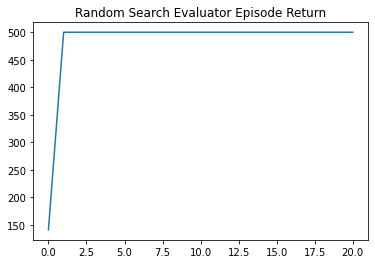

In [32]:
initial_learner_state = LearnerState(0, -float("inf"))

# Jit the learn function for some extra speed
random_policy_search_learn_jit = jax.jit(random_policy_search_learn)

initial_weights = np.array([1,1,1,1], "float32")
initial_params = RandomPolicySearchParams(initial_weights, initial_weights)

memory = AverageEpisodeReturnBuffer(num_episodes_to_store=20)

episode_return, evaluator_episode_returns = run_environment_loop(
                                        rng, 
                                        env, 
                                        initial_params, 
                                        random_policy_search_select_action_jit, 
                                        None, # no actor state
                                        random_policy_search_learn_jit, 
                                        initial_learner_state, 
                                        memory, 
                                        num_episodes=2001
                                    )

# Plot graph of evaluator episode returns
plt.plot(evaluator_episode_returns)
plt.title("Random Search Evaluator Episode Return")
plt.show()



Hopefully you found a set of optimal parameters on CartPole. You will know you have, if the evaluator episode return eventually reaches 500. If you didn't find optimal parameters, try running the environment loop again, you were probably just a little unlucky. That is the big limitation with random policy search after all, if you are unlucky you might not (randomly) stumble on the optimal policy.

So, in random policy search there is very little (if any) real learning going on. Next, lets look to implementing a simple RL algorithm instead, that can use its experience to guide the learning process, rather than just randomly sampling new weights. Hopefully this will help us more reliably find an optimal policy.

## Section 3: Policy Gradients (PG)
As discussed, the goal in RL is to find a policy which maximise the expected cummulative reward (return) the agent receives from the environment. We can write the expected return of a policy as:

$J(\pi_\theta)=\mathrm{E}_{\tau\sim\pi_\theta}\ [R(\tau)]$,

where $\pi_\theta$ is a policy parametrised by $\theta$, $\mathrm{E}$ means *expectation*, $\tau$ is shorthand for "*episode*", $\tau\sim\pi_\theta$ is shorthand for "*episodes sampled using the policy* $\pi_\theta$", and $R(\tau)$ is the return of episode $\tau$.

Then, the goal in RL is to find the parameters $\theta$ that maximise the function $J(\pi_\theta)$. One way to find these parameters is to perform gradient ascent on $J(\pi_\theta)$ with respect to the parameters $\theta$: 

$\theta_{k+1}=\theta_k + \alpha \nabla J(\pi_\theta)|_{\theta_{k}}$,

where $\nabla J(\pi_\theta)|_{\theta_{k}}$ is the gradient of the expected return with respect to the policy parameters $\theta_k$ and $\alpha$ is the step size. This quantity, $\nabla J(\pi_\theta)$, is also called the **policy gradient** and is very important in RL. If we can comput the policy gradient, theat we will have a means by which to directly optimise our policy.

As it turns out, there is a way for us to compute the policy gradient and the mathematical derivation can be found [here](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html). But for this tutorial we will ommit the derivation and just give you the result:


$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) R(\tau)]$

Informaly, the policy gradient is equal to the gradient of the log of the probability of the action chosen multiplied by the return of the episode in which the action was taken.


### REINFORCE
REINFORCE is a simple RL algorithm that uses the policy gradient to find the optimal policy by increasing the probability of choosing actions that tend to lead to high return episodes.

**Exercise 10:** Implement a function that takes the probability of an action and the return of the episode the action was taken in and returns the log of the probability multiplied by the return. Make sure you use jax so that we can jit the function.

**Usefull functions:**
*   [Jax numpy log](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.log.html)

In [33]:
def compute_weighted_log_prob(action_prob, episode_return):
    weighted_log_prob = None # you will need to overwrite this

    # YOUR CODE


    # END YOUR CODE

    return weighted_log_prob

# TEST: the result should be -22.314354
action_prob = 0.8
episode_return = 100
print("Weighted log prob:", compute_weighted_log_prob(action_prob, episode_return))

Weighted log prob: None


In [34]:
#@title Exercise 10 solution

def compute_weighted_log_prob(action_prob, episode_return):
    weighted_log_prob = None # you will need to overwrite this

    # YOUR CODE

    weighted_log_prob = jnp.log(action_prob) * episode_return

    # END YOUR CODE

    return weighted_log_prob

# TEST
action_prob = 0.8
episode_return = 100
print("Weighted log prob:", compute_weighted_log_prob(action_prob, episode_return))


Weighted log prob: -22.314354


### Rewards-to-go
The gradient of the log of the actions probability, weighted by the return of the episode will tend to push up the probability of actions that were in episodes whith high return, regardless of where in the episode the action was taken. This does not really make much sense because an action near the end of an episode may be reinforced because lots of reward was collected earlier on in the episode, before the action was taken. RL agents should really only reinforce actions on the basis of their *consequences*. Rewards obtained before taking an action have no bearing on how good that action was: only rewards that come after. The cummulative rewards received after an action was taken is called the **rewards-to-go** and can be computed as:

$\hat{R}_t=\sum_t^Tr_t$

Compare the rewards-to-go with the episode return:

$R(\tau)=\sum_{t=0}^Tr_t$

Thus, the policy gradient with rewards-to-go is given by:

$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) \hat{R}_t]$

**Exercise 11:** Implement a function that takes a list of all the rewards obtained in an episode and computes the rewards-to-go. Don't worry about using jax in this function. You can use regular Python operations like `for-loops`.

In [35]:
# Implement reward to go
def rewards_to_go(rewards):
    """
    This function should take a list of rewards as input and 
    compute the rewards-to-go for each timestep.
    
    Arguments:
        rewards[t] is the reward at time step t.

    Returns:
        rewards_to_go[t] should be the reward-to-go at timestep t.
    """

    rewards_to_go = []

    # YOUR CODE


    # END YOUR CODE

    return rewards_to_go

# TEST: The result should be [10, 9, 7, 4]
rewards = np.array([1,2,3,4])
print("Rewards-to-go:", rewards_to_go(rewards))

Rewards-to-go: []


In [36]:
#@title Exercise 11 solution

def rewards_to_go(rewards):
    rewards_to_go = []
    for i in range(len(rewards)):
        r2g = 0
        for j in range(i, len(rewards)):
            r2g += rewards[j]
        rewards_to_go.append(r2g)
    return rewards_to_go

# TEST: The result should be [10, 9, 7, 4]
rewards = np.array([1,2,3,4])
print("Rewards-to-go:", rewards_to_go(rewards))

Rewards-to-go: [10, 9, 7, 4]


In [37]:
# Faster rewards to go calculation using numpy
def rewards_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))

# TEST: The result should be [10, 9, 7, 4]
rewards = np.array([1,2,3,4])
print("Rewards-to-go:", rewards_to_go(rewards))

Rewards-to-go: [10  9  7  4]


Next we will need to make a new agent memory to store the rewards-to-go $R_t$ along with the observation $o_t$ and action $a_t$ at every timestep.

In [38]:
# Now we need a new episode memory buffer

EpisodeRewardsToGoMemory = collections.namedtuple("AverageEpisodeReturnMemory", ["obs", "action", "reward_to_go"])

class EpisodeRewardsToGoBuffer:

    def __init__(self, num_transitions_to_store=500, batch_size=500):
        self.batch_size = batch_size
        self.memory_buffer = collections.deque(maxlen=num_transitions_to_store)
        self.current_episode_transition_buffer = []

    def push(self, transition):
        self.current_episode_transition_buffer.append(transition)

        if transition.done:

            episode_rewards = []
            for t in self.current_episode_transition_buffer:
                episode_rewards.append(t.reward)

            r2g = rewards_to_go(episode_rewards)

            for i, t in enumerate(self.current_episode_transition_buffer):
                memory = EpisodeRewardsToGoMemory(t.obs, t.action, r2g[i])
                self.memory_buffer.append(memory)

            # Reset episode buffer
            self.current_episode_transition_buffer = []


    def is_ready(self):
        return len(self.memory_buffer) >= self.batch_size

    def sample(self):
        random_memory_sample = random.sample(self.memory_buffer, self.batch_size)

        obs_batch, action_batch, reward_to_go_batch = zip(*random_memory_sample)

        return EpisodeRewardsToGoMemory(
            np.stack(obs_batch).astype("float32"), 
            np.asarray(action_batch).astype("int32"), 
            np.asarray(reward_to_go_batch).astype("int32")
        )


# Instantiate Memory
REINFORCE_memory = EpisodeRewardsToGoBuffer(num_transitions_to_store=512, batch_size=256)

### Policy neural network
Next, we need to aproximate the policy using a simple neural network. Our policy neural network will have an input layer that takes the observation as input and passes it through two hidden layers and then outputs one scalar value for each of the possible actions. So, in CartPole the output layer will have size `2`.

[Haiku](https://github.com/deepmind/dm-haiku) is a library for implementing neural networks is Jax. Below we have implemented a simple function to make the policy network for you. 


In [39]:
def make_policy_network(num_actions: int, layers=[10, 10]) -> hk.Transformed:
  """Factory for a simple MLP network for the policy."""

  def policy_network(obs):
    network = hk.Sequential(
        [
            hk.Flatten(),
            hk.nets.MLP(layers + [num_actions])
        ]
    )
    return network(obs)

  return hk.without_apply_rng(hk.transform(policy_network))

Haiku networks have two important functions you need to know about. The first is the `<network>.init(<rng>, <input>)`, which returns a set of random initial parameters. The second method is the `<network>.apply(<params>, <input>)` which passes an input through the network using the set of parameters provided.

In [40]:
# Example
POLICY_NETWORK = make_policy_network(num_actions=2, layers=[20,20])
random_key = next(rng) # get next random key
dummy_obs = np.array([1,1,1,1], "float32")

REINFORCE_params = POLICY_NETWORK.init(random_key, dummy_obs)
print("Initial params:", REINFORCE_params.keys())

output = POLICY_NETWORK.apply(REINFORCE_params, dummy_obs)
print("Policy network output:", output)


Initial params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])
Policy network output: [0.08166866 1.0197883 ]


The outputs of our policy network are [logits](https://qr.ae/pv4YTe). To convert this into a probability distribution over actions we pass the logits to the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function (more on this later).

### Action selection

**Exercise 12:** Complete the function below which takes a vector of logits and randomly samples an action. 

**Useful functions:**
*   [Jax random categorical](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.categorical.html)

In [41]:
def sample_action(random_key, logits):
    action = None # you will need to overwrite this
    
    # YOUR CODE HERE


    # END YOUR code

    return action

# TEST
for i in range(10):
  print("Action:", sample_action(next(rng), np.array([0, 1], "float32")))

Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None


In [42]:
#@title Exercise 12 solution

def sample_action(random_key, logits):
    action = None # you will need to overwrite this
    
    # YOUR CODE HERE
    action = jax.random.categorical(random_key, logits)
    # END YOUR code

    return action

# TEST: 
for i in range(10):
  print("Action:", sample_action(next(rng), np.array([0, 1], "float32")))


Action: 0
Action: 0
Action: 1
Action: 0
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Action: 0


Notice in the tests that the actions are randomly sampled. Ofcourse the action with the higher probability will be chose more often because, but there is always a chance the action with the lower probability will be chosen. This is actually desirable in RL because it mean the agent will always try new things in the environment. We call this **exploring**. Exploring is important because it helps the agent discover new, possibly better, strategies in the environment. When an agent chooses the best possible action (given its current knowledge) we say the agent is being **greedy**.

**Exercise 13:** Complete the function below which takes a vector of logits and returns the greedy action. 

**Useful functions:**
*   [Jax numpy argmax](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.argmax.html)


In [43]:
def greedy_action(logits):
    action = None # you will need to overwrite this

    # YOUR CODE

    # END YOUR CODE

    return action

# TEST
for i in range(10):
    print("Action:", greedy_action(np.array([0, 1], "float32")))

Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None
Action: None


In [44]:
#@title Exercise 13 solution

def greedy_action(logits):
    action = None # you will need to overwrite this

    # YOUR CODE
    action = jnp.argmax(logits)
    # END YOUR CODE

    return action

# TEST
for i in range(10):
    print("Action:", greedy_action(np.array([0, 1], "float32")))


Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1


Notice that the greed action selector always chooses the same action, namely the one with the highest probability (or equivalently the largets logit). Next, we will implement the REINFORCE `select_action` function. The function passes the observation through the policy neural network to get loggits and then uses thos to chose an action. If `evaluation` is `True`, the greedy action will be chosen. Otherwise, the action is sampled from the action probability distribution given by the logits.


In [45]:
def REINFORCE_select_action(key, params, actor_state, obs, evaluation=False):
    obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim
    logits = POLICY_NETWORK.apply(params, obs)[0] # remove batch dim

    sampled_action = sample_action(key, logits)

    best_action = greedy_action(logits)

    action = jax.lax.select(
        evaluation,
        best_action,
        sampled_action
    )
    
    return action, actor_state

# TEST
action, actor_state = REINFORCE_select_action(
    key=next(rng),
    params=REINFORCE_params, # we instantiated this earlier
    actor_state=None, # not used
    obs=np.array([1,1,1,1], "float32") # dummy obs
)

print("Action:", action)

Action: 1


Now that we finished the REINFORCE action selection function, all we have left to do is make a REINFORCE learn function. The learn function should use the `weighted_log_prob` function we made earlier to compute the policy gradient and apply the updates to our neural network.

### Network Optimiser

To apply updates to our neural network we will use a Jax library called [Optax](https://github.com/deepmind/optax). Optax has an implementation of the [Adam optimizer](https://www.geeksforgeeks.org/intuition-of-adam-optimizer/) which we can use.

In [46]:
REINFORCE_OPTIMIZER = optax.adam(1e-3)
REINFORCE_optim_state = REINFORCE_OPTIMIZER.init(REINFORCE_params)

### Policy gradient loss

**Exercise 14:** Complete the `pg_loss` function below.

**Useful methods:**
*   [Jax softmax](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.softmax.html)
*   [Jax one-hot vector](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.one_hot.html)
*   [Jax dot product](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.dot.html)

In [48]:
def pg_loss(action, logits, reward_to_go):
    chosen_action_prob = 0.0 # you will need to overwrite this

    # YOUR CODE

    # HINT all_action_probs = ... (convert logits into probs)

    # HINT extract the prob of the desired action.
    # One way to achieve this is to use a one-hot vector and a dot product...?

    # END YOUR CODE
    weighted_log_prob = compute_weighted_log_prob(
                            chosen_action_prob, 
                            reward_to_go
                        )
    
    loss = - weighted_log_prob # negative because we want gradient `ascent`
    
    return loss

# TEST 
print("Policy gradient loss:", pg_loss(0, np.array([0,1], "float32"), 10))

Policy gradient loss: inf


In [49]:
#@title Exercise 14 solution

def pg_loss(action, logits, reward_to_go):

    # YOUR CODE
    
    all_action_probs = jax.nn.softmax(logits)
    action_mask = jax.nn.one_hot(action, logits.shape[0])
    chosen_action_prob = jnp.dot(all_action_probs, action_mask)

    # END YOUR CODE
    
    weighted_log_prob = compute_weighted_log_prob(
                            chosen_action_prob, 
                            reward_to_go
                        )
    
    loss = - weighted_log_prob 
    
    return loss

# TEST 
print("Policy gradient loss:", pg_loss(0, np.array([0,1], "float32"), 10))

Policy gradient loss: 13.132616


Now, when we do a policy gradient update step we are going to want to do it using a batch of experience, rather than just a single experience like above. We can use Jax's [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) function to easily make our `pg_loss` function work on a batch of experience.

In [50]:
def batched_pg_loss(params, obs_batch, action_batch, reward_to_go_batch):
    logits_batch = POLICY_NETWORK.apply(params, obs_batch) # network we made earlier
    pg_loss_batch = jax.vmap(pg_loss)(action_batch, logits_batch, reward_to_go_batch) # add batch
    mean_pg_loss = jnp.mean(pg_loss_batch)
    return mean_pg_loss

# TEST
obs_batch = np.array([[1,0,0,1],[1,0,0,1],[1,0,0,1]])
actions_batch = np.array([1,0,0])
rew2go_batch = np.array([2.3, 4.3, 2.1])

loss = batched_pg_loss(REINFORCE_params, obs_batch, actions_batch, rew2go_batch)

print("PG loss on batch:", loss)

PG loss on batch: 2.4175563


Now we can make the REINFORCE learn function.

In [52]:
REINFORCELearnerState = collections.namedtuple("LearnerState", ["optim_state"])

def REINFORCE_learn(key, params, learner_state, memory):
    
    #Get Policy gradient by using `jax.grad()` on `batched_pg_loss`
    grad_loss = jax.grad(batched_pg_loss)(params, memory.obs, memory.action, memory.reward_to_go)

    # Get param updates using gradient and optimizer
    updates, new_optim_state = REINFORCE_OPTIMIZER.update(grad_loss, learner_state.optim_state)

    # Apply updates to params
    params = optax.apply_updates(params, updates)

    return params, REINFORCELearnerState(new_optim_state) # update learner state

# Lets jit the learn function and the select action function for some extra speed
REINFORCE_learn_jit = jax.jit(REINFORCE_learn)
REINFORCE_select_action_jit = jax.jit(REINFORCE_select_action)

Now we can train our REINFORCE agent by putting everything together using the environment loop. 

Episode: 0	Episode Return: 10.0	Average Episode Return: 10.0	Evaluator Episode Return: 11.21875
Episode: 100	Episode Return: 14.0	Average Episode Return: 25.4	Evaluator Episode Return: 176.8125
Episode: 200	Episode Return: 30.0	Average Episode Return: 107.65	Evaluator Episode Return: 328.09375
Episode: 300	Episode Return: 319.0	Average Episode Return: 238.75	Evaluator Episode Return: 368.40625
Episode: 400	Episode Return: 225.0	Average Episode Return: 291.45	Evaluator Episode Return: 312.5625
Episode: 500	Episode Return: 216.0	Average Episode Return: 297.05	Evaluator Episode Return: 339.28125
Episode: 600	Episode Return: 333.0	Average Episode Return: 289.15	Evaluator Episode Return: 395.96875
Episode: 700	Episode Return: 500.0	Average Episode Return: 452.95	Evaluator Episode Return: 500.0
Episode: 800	Episode Return: 364.0	Average Episode Return: 389.1	Evaluator Episode Return: 444.21875
Episode: 900	Episode Return: 500.0	Average Episode Return: 497.55	Evaluator Episode Return: 500.0
E

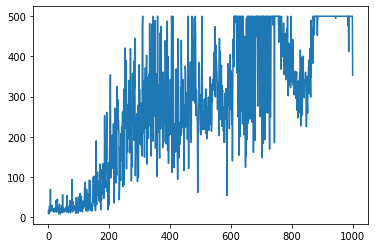

In [53]:
learner_state = REINFORCELearnerState(REINFORCE_optim_state)
actor_state = None # not used

episode_returns, evaluator_returns = run_environment_loop(rng, env, REINFORCE_params, REINFORCE_select_action_jit , actor_state, 
    REINFORCE_learn_jit, learner_state, REINFORCE_memory, num_episodes=1001)

# Plot the episode returns over time
plt.plot(episode_returns)
plt.show()


## Section 4: Q-Learning
Another common aproach to finding an optimal policy in an environment in RL is via Q-learning. 

### Value functions
In Q-learnig the agent learns a function that aproximates the **value** of states and actions. By *value* we mean the return you expect to receive if you start in a particular state $s_t$, take a particular action $a_t$, and then act according to a particular policy $\pi$ forever after. There are two types of **value functions**:
1. The **state value function** which returns the expected value starting from a particular state.

    $V_\pi(s)=\mathrm{E}_{\tau\sim\pi}\left[R(\tau) \mid s_0=s\right]$

2. The **state-action value function** which returns the expected value of starting from a particular state and choosing a particular action.

    $Q_\pi(s,a)=\mathrm{E}_{\tau\sim\pi}\left[R(\tau) \mid s_0=s,\ a_t=a\right]$

We say that the value function $V_\pi(s)$ or $Q_\pi(s,a)$ is the **optimal** value function if the policy $\pi$ is an optimal policy. We denote the optimal value functions as follows:

1.   $V_\ast(s)=max_\pi \ \mathrm{E}_{\tau\sim\pi}\left[R(\tau) \mid s_0=s\right]$
2.   $Q_\ast(s,a)=max_\pi \  \mathrm{E}_{\tau\sim\pi}\left[R(\tau) \mid s_0=s,\ a_0=a\right]$

There is an important relationship between the optimal action $a_\ast$ in a state $s$ and the optimal state-action value function $Q_\ast$. Namely, the optimal action $a_\ast$ in state $s$ is equal to the action that maximises the optimal state-action value function. This relationship naturally induces an optimal policy:

$\pi_\ast(s)=\mathop{argmax}_a\ Q_\ast(s, a)$

Thus, if we can learn to aproximate the optimal Q-function, then we naturally have an optimal policy. This is the arpoach taken in RL algorithms that use Q-learning.

### Greedy action selection

**Exercise 15:** Lets implement a function that, given a vector of Q-values, returns the action with the largets Q-value (i.e. the greedy action).

**Useful methods:**
*   [Jax argmax](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.argmax.html)

In [54]:
# Implement a function takes q-values as input and returns the greedy_action
def select_greedy_action(q_values):
    action = None # you will need to overwrite this

    # YOUR CODE


    # END YOUR CODE

    return action

# TEST
q_values = np.array([1, 3])
print("Greedy action:", select_greedy_action(q_values))

Greedy action: None


In [55]:
#@title Exercise 15 solution


def select_greedy_action(q_values):
    action = None # you will need to overwrite this
    
    # YOUR CODE

    action = jnp.argmax(q_values)

    # END YOUR CODE

    return action

# TEST
q_values = np.array([1, 3])
print("Greedy action:", select_greedy_action(q_values))

Greedy action: 1


### Q-Network
We can use haiku to make a neural network to aproximate the Q-function. The network will take an observation as input and then output a Q-value for each of the avaliable actions. So in the case of CartPole, the output of the network will have size $2$.

In [60]:
def build_network(num_actions: int, layers=[10, 10]) -> hk.Transformed:
  """Factory for a simple MLP network for approximating Q-values."""

  def q_network(obs):
    network = hk.Sequential(
        [hk.Flatten(),
         hk.nets.MLP(layers + [num_actions])])
    return network(obs)

  return hk.without_apply_rng(hk.transform(q_network))

# Initialise Q-network
Q_NETWORK = build_network(num_actions=2)
dummy_obs = jnp.zeros((1,4), jnp.float32)
Q_NETWORK_WEIGHTS = Q_NETWORK.init(next(rng), dummy_obs)
print("Q-Learning params:", Q_NETWORK_WEIGHTS.keys())

Q-Learning params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])


### The Bellman Equations
The value functions can be written recursivly as:
*   $V_{\pi}(s) = \underset{\substack{a \sim \pi \\ s^{\prime} \sim P}}{\mathrm{E}}\left[r(s, a)+\gamma V_{\pi}\left(s^{\prime}\right)\right]$
*   $Q_{\pi}(s, a) =\underset{s^{\prime} \sim P}{\mathrm{E}}\left[r(s, a)+\gamma \underset{a^{\prime} \sim \pi}{\mathrm{E}}\left[Q_{\pi}\left(s^{\prime}, a^{\prime}\right)\right]\right]$

Where $s' \sim P$ is shorthand for for indicating that the next state $s'$ is sampled from the environment’s transition rules $P$. Intuitivly, these equations say the value of state you are in is equal to the reward you expect to get from being there, plus the value of the state you transition to next. The Bellman equations for the optimal value functions are:
*   $V_{*}(s) = \underset{a}{\mathop{max}} \underset{s^{\prime} \sim P}{\mathrm{E}}\left[r(s, a)+\gamma V^{*}\left(s^{\prime}\right)\right]$
*   $Q_{*}(s, a) =\underset{a}{\mathop{max}} \underset{s^{\prime} \sim P}{\mathrm{E}}\left[r(s, a)+\gamma \underset{a^{\prime} \sim \pi}{\mathrm{E}}\left[Q_{\pi}\left(s^{\prime}, a^{\prime}\right)\right]\right]$



For a more indepth discussion of the Bellman Equations, see the [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) website.

### The Bellman Backup
To learn to aproximate the optimal Q-value function, we can use the right-hand side of the Bellman equation as an update rule. In other words, suppose we have a Q-function $Q_\theta$ aproximated using parameters $\theta$ then we can iterativly update the paramters such that

$Q_\theta(s,a)\leftarrow r(s, a) + \underset{a'}{\max}\ Q_\theta(s', a')$.

Intuitivly, this says that the aproximation of the Q-value of action $a$ in state $s$ should be updated such that it is closer to being equal to the reward received from the environment $r(s, a)$ plus the value of best possible action in the next state $s'$. We can perform this optimisation by minimising the difference between the left and right-hand side, with respect to the parameters $\theta$ using gradient descent. We can measure the difference between the two values using the [squared-error](https://en.wikipedia.org/wiki/Mean_squared_error#Loss_function).

**Exercise X:** Implement the squared-error function.

In [61]:
def compute_squared_error(pred, target):
    squared_error = None

    # YOUR CODE


    # END YOUR CODE

    return squared_error

In [62]:
def compute_squared_error(pred, target):
    squared_error = None

    # YOUR CODE
    
    squared_error = jnp.square(pred - target)

    # END YOUR CODE
    return squared_error

The right-hand side of the Bellman equation is sometimes called the **Bellman target**.

**Exercise X:** Implement a function that computes the Bellman target (right-hand side of the equation). If the timetep is the last timestep, then the Bellman target should just be equal to the reward, with not extra value at the end.  

In [63]:
# Bellman target
def compute_bellman_target(reward, done, next_q_values):
    """A function to compute the bellman target.
    
    Args:
        reward: a scalar reward.
        done: a scalar of value either 1.0 or 0.0, indicating if the transition is a terminal one.
        next_q_values: a vector of q_values for the next state. One for each action.
    Returns:
        A scalar equal to the bellman target.
    
    """
    bellman_target = None # you will need to override this

    # YOUR CODE



    # END YOUR CODE

    return bellman_target

In [64]:
# Bellman target
def compute_bellman_target(reward, done, next_q_values):
    """A function to compute the bellman target.
    
    Args:
        reward: a scalar reward.
        done: a scalar of value either 1.0 or 0.0, indicating if the transition is a terminal one.
        next_q_values: a vector of q_values for the next state. One for each action.
    Returns:
        A scalar equal to the bellman target.
    
    """
    bellman_target = None # you will need to override this

    # YOUR CODE

    bellman_target = reward + (1.0 - done) * jnp.max(next_q_values)

    # END YOUR CODE

    return bellman_target


We can now combine these two functions to compute the loss for Q-learning. The Q-learning loss is equal to the squared difference between the predicted Q-value of an action and its corresponding Bellman target.

**Exercise X:** Implement the Q-learning loss.

In [65]:
def q_learning_loss(q_values, action, reward, done, next_q_values):
    """Implementation of the Q-learning loss.T
    
    Args:
        q_values: a vector of Q-values, one for each action.
        action: an integer, giving the action that was chosen. q_values[action] is the value of the chose action.
        done: is a scalar that indicates if this is a terminal transition.
        next_q_values: a vector of Q-values in the next state.
    Returns:
        The squared difference between the q_value of the chosen action and the bellman target.
    """
    squared_error = None

    # YOUR CODE

    # END YOUR CODE
    
    return squared_error

In [66]:
def q_learning_loss(q_values, action, reward, done, next_q_values):
    """Implementation of the Q-learning loss.T
    
    Args:
        q_values: a vector of Q-values, one for each action.
        action: an integer, giving the action that was chosen. q_values[action] is the value of the chose action.
        done: is a scalar that indicates if this is a terminal transition.
        next_q_values: a vector of Q-values in the next state.
    Returns:
        The squared difference between the q_value of the chosen action and the bellman target.
    """
    squared_error = None

    # YOUR CODE
    action_q_value = q_values[action]
    bellman_target = compute_bellman_target(reward, done, next_q_values)
    squared_error = compute_squared_error(action_q_value, bellman_target)
    # END YOUR CODE
    
    return squared_error

We can use `jax.vmap` to modify the `q_learning_loss` function so that it accepts batches of transitions. In adition, we will compute the Q-values by passing the observations through the `Q_NETWORK`. 

In [127]:
def batched_q_learning_loss(params, obs, actions, rewards, next_obs, dones):
    q_values = Q_NETWORK.apply(params, obs)
    next_q_values = Q_NETWORK.apply(params, next_obs)
    next_q_values = jax.lax.stop_gradient(next_q_values) # stop the gradients
    squared_error = jax.vmap(q_learning_loss)(q_values, actions, rewards, dones, next_q_values)
    mean_squared_error = jnp.mean(squared_error)
    return mean_squared_error

### Target Q-network
Unfortunatly, it turns out that this form of the loss function is quite unstable and the Q-learner will often fail to converge on the optimal policy. The instability is there is a simple implementation trick we need to use inorder to get Q-learning to be more stable when using a neural network to aproximate the Q-function.

### Replay Buffer
For Q-learning we will need an agent memory that stores entire transitions: `obs`, `action`, `reward`, `next_obs`, `done`. When we retrieve transitions from the memory, they should be chose randomly. In RL we often call such a module a **replay buffer**.

In [128]:
class TransitionMemory(object):
  """A simple Python replay buffer."""

  def __init__(self, max_size=5000, batch_size=256):
    self.batch_size = batch_size
    self.buffer = collections.deque(maxlen=max_size)

  def push(self, transition):

      self.buffer.append(
          (transition.obs, transition.action, transition.reward, 
           transition.next_obs, transition.done)
      )

  
  def is_ready(self):
    return self.batch_size <= len(self.buffer)

  def sample(self):
    random_replay_sample = random.sample(self.buffer, self.batch_size)
    obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = zip(*random_replay_sample)

    return Transition(
        np.stack(obs_batch).astype("float32"), 
        np.asarray(action_batch).astype("int32"), 
        np.asarray(reward_batch).astype("float32"), 
        np.stack(next_obs_batch).astype("float32"), 
        np.asarray(done_batch).astype("float32")
    )

Q_LEARNING_MEMORY = TransitionMemory(max_size=5000, batch_size=256)

### Q-learn function
We now have everything we need to implement the `q_learn_step` function which takes some batch of transitions and does a step of Q-learning to update the network paramters. Once again, we will use optax to update our neural network parameters.

In [141]:
QLearnerState = collections.namedtuple("LearnerState", ["optim_state"])

# Initialise Q-network optimizer
Q_LEARN_OPTIMIZER = optax.adam(1e-3) # learning rate = 0.001
Q_LEARN_OPTIM_STATE = Q_LEARN_OPTIMIZER.init(Q_NETWORK_WEIGHTS)
Q_LEARNING_LEARN_STATE = QLearnerState(Q_LEARN_OPTIM_STATE)

In [130]:
def q_learner_step(rng, params, learner_state, memory):
    grad_loss = jax.grad(batched_q_learning_loss)(params, memory.obs, 
                                            memory.action, memory.reward, 
                                            memory.next_obs, memory.done,
                                            )

    updates, opt_state = Q_LEARN_OPTIMIZER.update(grad_loss, learner_state.optim_state)

    params = optax.apply_updates(params, updates)

    # Increment learner step counter
    learner_state = QLearnerState(opt_state)

    return params, learner_state

### Random exploration
We almost have everything we need for a functioning Q-learning agent. But one problem is that if we always chose the action with the highest Q-value as our policy then the agent's policy will be completly deterministic. This means the agent will always chose the same strategy. At the start of training this can pose a problem because the Q-network will be very inaccurate (i.e. a bad aproximation of the true Q-function) and so the agent will consistently choose suboptimal actions. Moreover, the agent will never deviate from its sub-optimal strategy and so never explores new, alternative actions. As a result, the Q-network remains inaccurate. Ideally, the agent should try out many different strategies so that it can observe the outcomes (rewards) of its actions in different states and so improve its approximation of the Q-function.

One easy way to ensure that the agent tries out many different actions is to let it peiodically chose some random actions, instead of just the greedy (best) action.

**Exercise 16:** Implement a function that, given the number of possible actions, returns a random action.

**Useful methods:**

*   [Jax random int](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.randint.html)

In [56]:
def select_random_action(key, num_actions):
    action = None

    # YOUR CODE


    # END YOUR CODE

    return action

# TEST
for i in range(10):
  print(f"Random action number {i}: {select_random_action(next(rng), 2)}")

Random action number 0: None
Random action number 1: None
Random action number 2: None
Random action number 3: None
Random action number 4: None
Random action number 5: None
Random action number 6: None
Random action number 7: None
Random action number 8: None
Random action number 9: None


In [57]:
#@title Exercise 16 solution

def select_random_action(key, num_actions):
    action = None

    # YOUR CODE

    action = jax.random.randint(
        key, 
        shape=(1,), 
        minval=0, 
        maxval=num_actions
    )[0] # important to take zeroth element

    # END YOUR CODE

    return action

# TEST
for i in range(10):
  print(f"Random action number {i}: {select_random_action(next(rng), 2)}")

Random action number 0: 0
Random action number 1: 1
Random action number 2: 1
Random action number 3: 0
Random action number 4: 0
Random action number 5: 1
Random action number 6: 1
Random action number 7: 1
Random action number 8: 0
Random action number 9: 1


### Epsilon-greedy action selection
At the start of training, when the accuracy of the Q-network is low, it is worthwhile for the agent to mostly take random actions. But overtime as the accuracy of the Q-network improves the agent should start taking fewer random actions and instead start chosing the greedy actions with respect to the Q-values. In RL we often call the ratio of random to greedy actions **epsilon**. Epsilon is usually a decimal value in the interval $[0,1]$, where for example $epsilon=0.4$ means that the agent choses a random action 40% of the time and the greedy action 60% of the time. Its common in RL to linearly decrease the value of epsilon ove time so that the agent becomes increasingly greedy as the accuracy of its Q-network improves through learning.


**Exercise 17:** Implement a function that takes the number of timesteps as input and returns the current epsilon value.

In [157]:
EPSILON_DECAY_TIMESTEPS = 1_000
EPSILON_MIN = 0.1 # 10%

def get_epsilon(num_timesteps):
    epsilon = None

    # YOUR CODE


    # END YOUR CODE

    return epsilon

# TEST

print("Epsilon after 10 timesteps:", get_epsilon(10))
print("Epsilon after 10 010 timesteps:", get_epsilon(5_010))


Epsilon after 10 timesteps: None
Epsilon after 10 010 timesteps: None


In [158]:
#@title Exercise 17 solution

def get_epsilon(num_timesteps):

    # YOUR CODE
    epsilon = 1.0 - num_timesteps / EPSILON_DECAY_TIMESTEPS

    epsilon = jax.lax.select(
        epsilon < EPSILON_MIN,
        EPSILON_MIN,
        epsilon
    )
    # END YOUR CODE

    return epsilon

# TEST

print("Epsilon after 10 timesteps:", get_epsilon(10))
print("Epsilon after 10 010 timesteps:", get_epsilon(5_010))


Epsilon after 10 timesteps: 0.99
Epsilon after 10 010 timesteps: 0.1


**Exercise X:** Now lets put these functions together to do epsilon-greedy action selection.

In [152]:
def select_epsilon_greedy_action(key, q_values, num_timesteps):
    action = None
    
    # YOUR CODE HERE


    # END YOUR CODE

    return action

# TEST
dummy_q_values = jnp.array([0,1], jnp.float32)
num_timesteps = 5010 # very greedy
print("Greedy actions:", end=" ")
for i in range(10):
    print(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps), end=" ")
print()

num_timesteps = 0 # completly random
print("Random actions:", end=" ")
for i in range(10):
    print(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps), end=" ")

Greedy actions: None None None None None None None None None None 
Random actions: None None None None None None None None None None 

In [159]:
#@title Exercise 18 solution

# Now make a function that takes an epsilon-greedy action

def select_epsilon_greedy_action(key, q_values, num_timesteps):

    epsilon = get_epsilon(num_timesteps)

    should_explore = jax.random.uniform(key, (1,))[0] < epsilon

    num_actions = len(q_values)

    action = jax.lax.select(
        should_explore,
        select_random_action(key, num_actions), 
        select_greedy_action(q_values)
    )

    return action

# TEST
dummy_q_values = jnp.array([0,1], jnp.float32)
num_timesteps = 5010 # very greedy
print("Greedy actions:", end=" ")
for i in range(10):
    print(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps), end=" ")
print()

num_timesteps = 0 # completly random
print("Random actions:", end=" ")
for i in range(10):
    print(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps), end=" ")

Greedy actions: 1 1 0 1 1 1 1 1 0 1 
Random actions: 0 1 0 1 0 1 0 0 1 0 

### Q-learning select action

We now have everything we need to make the `q_learning_select_action` function. We will use the `actor_state` to store a counter which keeps track of the current number of timesteps.

In [160]:
# Actor state stores the current number of timesteps
QActorState = collections.namedtuple("ActorState", ["count"])

def q_learning_select_action(key, params, actor_state, obs, evaluation=False):
    obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim
    q_values = Q_NETWORK.apply(params, obs)[0] # remove batch dim

    action = select_epsilon_greedy_action(key, q_values, actor_state.count)
    greedy_action = select_greedy_action(q_values)

    action = jax.lax.select(
        evaluation,
        greedy_action,
        action
    )

    next_actor_state = QActorState(actor_state.count + 1) # increment timestep counter

    return action, next_actor_state

Q_LEARNING_ACTOR_STATE = QActorState(0) # counter set to zero

### Training
We can now put everything together using the agent-environment loop. But first,lets jit the select action function and the learn function for some extra speed.

Episode: 0	Episode Return: 12.0	Average Episode Return: 12.0	Evaluator Episode Return: 9.28125
Episode: 100	Episode Return: 9.0	Average Episode Return: 20.9	Evaluator Episode Return: 9.5
Episode: 200	Episode Return: 24.0	Average Episode Return: 25.8	Evaluator Episode Return: 30.96875
Episode: 300	Episode Return: 195.0	Average Episode Return: 159.1	Evaluator Episode Return: 264.71875
Episode: 400	Episode Return: 500.0	Average Episode Return: 500.0	Evaluator Episode Return: 500.0
Episode: 500	Episode Return: 500.0	Average Episode Return: 500.0	Evaluator Episode Return: 500.0
Episode: 600	Episode Return: 306.0	Average Episode Return: 285.35	Evaluator Episode Return: 471.09375
Episode: 700	Episode Return: 500.0	Average Episode Return: 461.5	Evaluator Episode Return: 499.9375
Episode: 800	Episode Return: 500.0	Average Episode Return: 495.75	Evaluator Episode Return: 500.0
Episode: 900	Episode Return: 500.0	Average Episode Return: 485.95	Evaluator Episode Return: 500.0
Episode: 1000	Episode 

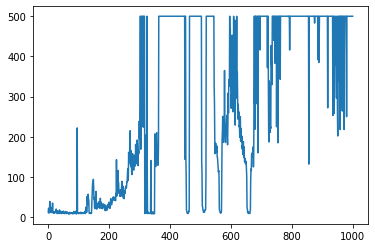

In [162]:
# Jit functions
q_learning_select_action_jit = jax.jit(q_learning_select_action)
q_learner_step_jit = jax.jit(q_learner_step)

# Initialise memory
memory = TransitionMemory(5_000, 512) # store 10000 transitions

# Run environment loop
episode_returns, evaluator_returns = run_environment_loop(
                                        rng, 
                                        env, 
                                        Q_NETWORK_WEIGHTS, 
                                        q_learning_select_action_jit, 
                                        Q_LEARNING_ACTOR_STATE,
                                        q_learner_step_jit, 
                                        Q_LEARNING_LEARN_STATE, 
                                        memory,
                                        num_episodes=1_001,
                                        learn_steps_per_episode=8
                                    )

plt.plot(episode_returns)
plt.show()

As you can see from the plot of episode returns, our Q-learning implementation is fairly unstable. It turns out that there are a number of implementation tricks we need to use in order to get Q-learning to work reliably with neural networks. These implementation tricks are out of the scope of this tutorial but they are included in the **Additional Resources** at the end of this tutorial. The reader is encourged to try and improve this Q-learning implementation by implementing those tricks.

## Additional Resources
**Intermediate:**
*   [REINFORCE with baseline](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#baselines-in-policy-gradients)
*   [Deep Q-Network (DQN)](https://arxiv.org/abs/1312.5602v1)

**Advanced:**:
*   [Double DQN](https://arxiv.org/pdf/1509.06461.pdf)
*   [Proximal Policy Optimisation (PPO)](https://arxiv.org/pdf/1707.06347.pdf)

## Conclusion
**Summary:**

[Summary of the main points/takeaways from the prac.]

**Next Steps:** 

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:** 

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:** 

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
#@title Generate Feedback Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />